# Data Science
- Student: Dmytro Geleshko
- Group: IP-91
- Var: 6

## Task:
- Quadratic function
- Normal noise
- Anomalies
- LSM

## Imports

In [103]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Config

In [104]:
np.random.seed(1)
plt.rcParams["figure.figsize"] = (20, 8)
pd.set_option("display.max_columns", None)
pd.options.display.float_format = "{:,.3f}".format

## Parameters

In [105]:
PARAM_selection_size = 1000
PARAM_anomaly_size = 0.1
PARAM_normal_mean = 0
PARAM_normal_std = 10
PARAM_max_test_pow = 6

## Functions

In [106]:
def describe_all(_data, trend_column):
    """Prints stats of all data in dictionary"""
    # create df
    df = pd.DataFrame(_data)
    # pop trend data
    trend_data = df.pop(trend_column)
    # remove trend from other data
    for column in df.columns:
        df[column] = df[column] - trend_data
    # find stats and calc var
    stats = df.describe()
    stats.loc["var"] = stats.loc["std"] ** 2
    return stats

In [107]:
def lsm(y, pol_pow):
    # Reshape y to row vector
    Y = y.reshape(-1, 1)
    # Creating F matrix, 1, x, x^2, ..., x^PARAM_max_pow
    F = np.ones((PARAM_selection_size, pol_pow + 1))
    for i in range(1, pol_pow + 1):
        # Pow to
        F[:, i] = np.power(np.arange(0, PARAM_selection_size), i)
    # Calculations
    FT = F.T
    FF = np.dot(FT, F)
    FFI = np.linalg.inv(FF)
    FFIFT = np.dot(FFI, FT)
    C = np.dot(FFIFT, Y)
    result = np.dot(F, C)
    # returning array, reshaped from row vector to 1d
    return result.reshape(-1)

## Errors and anomalies

In [108]:
_normal = np.random.normal(PARAM_normal_mean, PARAM_normal_std, PARAM_selection_size)

# adding anomalies at indexes, drawn from uniform distribution
_normal_anomaly = _normal.copy()
for i in np.unique(np.random.randint(0, PARAM_selection_size, int(PARAM_selection_size * PARAM_anomaly_size))):
    while abs(_normal_anomaly[i]) < _normal.std() * 3:
        _normal_anomaly[i] *= 2

## Data

In [109]:
data = {}

# quadratic + noise + anomalies
data["quadratic"] = np.square(np.linspace(0, 10, PARAM_selection_size))
data["quadratic_normal"] = data["quadratic"].copy() + _normal
data["quadratic_normal_anomalies"] = data["quadratic"].copy() + _normal_anomaly

describe_all(data, "quadratic")

,quadratic_normal,quadratic_normal_anomalies
count,"1,000.000","1,000.000"
mean,0.388,0.443
std,9.815,16.185
min,-30.538,-55.862
25%,-6.002,-6.742
50%,0.413,0.451
75%,7.040,7.815
max,39.586,58.613
var,96.333,261.955


## Finding the right order of polynom

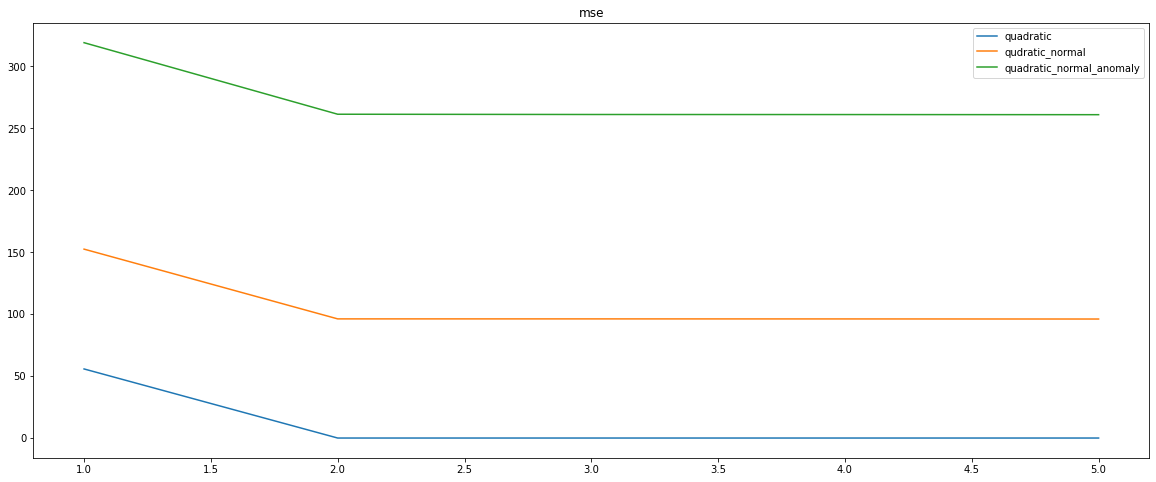

In [110]:
errs = []
errs_normal = []
errs_normal_anomaly = []

pow_range = range(1, PARAM_max_test_pow)
for power in pow_range:
    errs.append((np.square(data["quadratic"] - lsm(data["quadratic"], power))).mean())
    errs_normal.append((np.square(data["quadratic_normal"] - lsm(data["quadratic_normal"], power))).mean())
    errs_normal_anomaly.append((np.square(data["quadratic_normal_anomalies"] - lsm(data["quadratic_normal_anomalies"], power))).mean())

plt.title("mse")
plt.plot(pow_range, errs, label="quadratic")
plt.plot(pow_range, errs_normal, label="qudratic_normal")
plt.plot(pow_range, errs_normal_anomaly, label="quadratic_normal_anomaly")
plt.legend()
plt.show()

In [111]:
PARAM_rec_pow = 2

## LSM Data

In [112]:
data["quadratic_lsm"] = lsm(data["quadratic"], PARAM_rec_pow)
data["quadratic_normal_lsm"] = lsm(data["quadratic_normal"], PARAM_rec_pow)
data["quadratic_normal_anomalies_lsm"] = lsm(data["quadratic_normal_anomalies"], PARAM_rec_pow)

describe_all(data, "quadratic")

,quadratic_normal,quadratic_normal_anomalies,quadratic_lsm,quadratic_normal_lsm,quadratic_normal_anomalies_lsm
count,"1,000.000","1,000.000","1,000.000","1,000.000","1,000.000"
mean,0.388,0.443,0.000,0.388,0.443
std,9.815,16.185,0.000,0.180,0.493
min,-30.538,-55.862,-0.000,0.164,-0.087
25%,-6.002,-6.742,0.000,0.226,-0.005
50%,0.413,0.451,0.000,0.348,0.296
75%,7.040,7.815,0.000,0.530,0.817
max,39.586,58.613,0.000,0.773,1.559
var,96.333,261.955,0.000,0.032,0.243


## Detecting anomalies

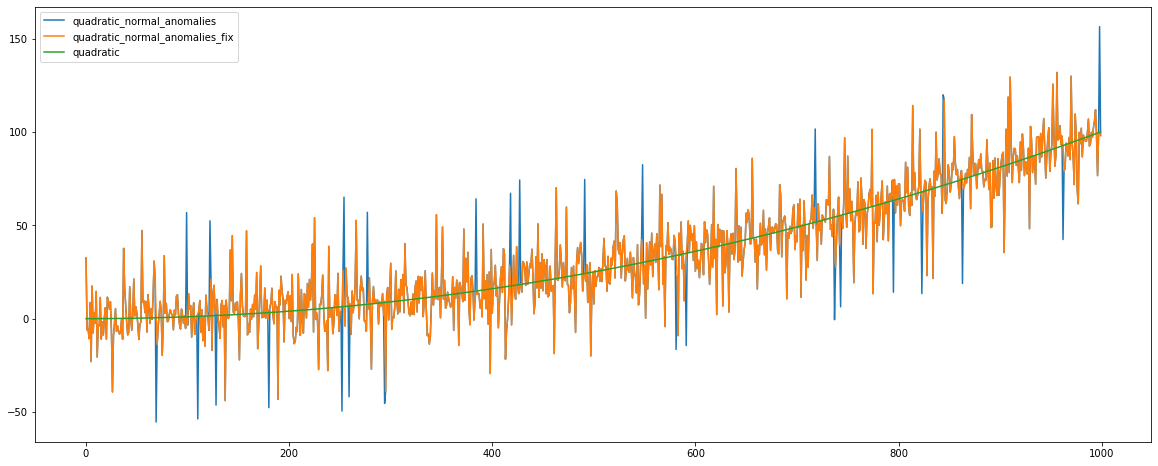

In [122]:
anomal_coef = 3

std3 = anomal_coef * (data["quadratic_normal_anomalies"] - data["quadratic_normal_anomalies_lsm"]).std()

anomaly_pos = np.abs(data["quadratic_normal_anomalies"] - data["quadratic_normal_anomalies_lsm"]) > std3

data["quadratic_normal_anomalies_fix"] = data["quadratic_normal_anomalies"].copy()
data["quadratic_normal_anomalies_fix"][anomaly_pos] = data["quadratic_normal_anomalies_lsm"][anomaly_pos]
anomaly_count = anomaly_pos.sum()

plt.plot(data["quadratic_normal_anomalies"], label="quadratic_normal_anomalies")
plt.plot(data["quadratic_normal_anomalies_fix"], label="quadratic_normal_anomalies_fix")
#plt.plot(data["quadratic_normal"], label="quadratic_normal")
plt.plot(data["quadratic"], label="quadratic")
plt.legend()
plt.show()

## Plots

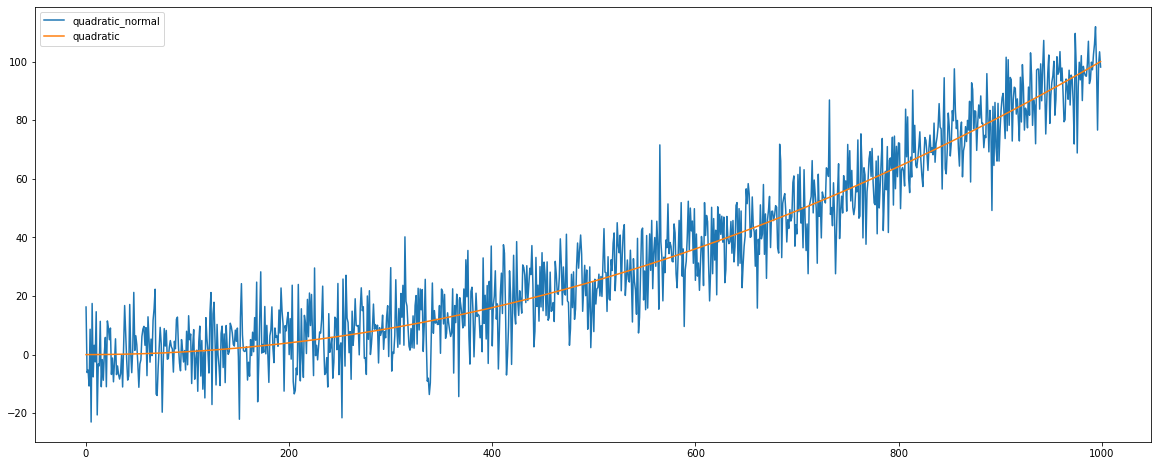

In [113]:
plt.plot(data["quadratic_normal"], label="quadratic_normal")
plt.plot(data["quadratic"], label="quadratic")
plt.legend()
plt.show()

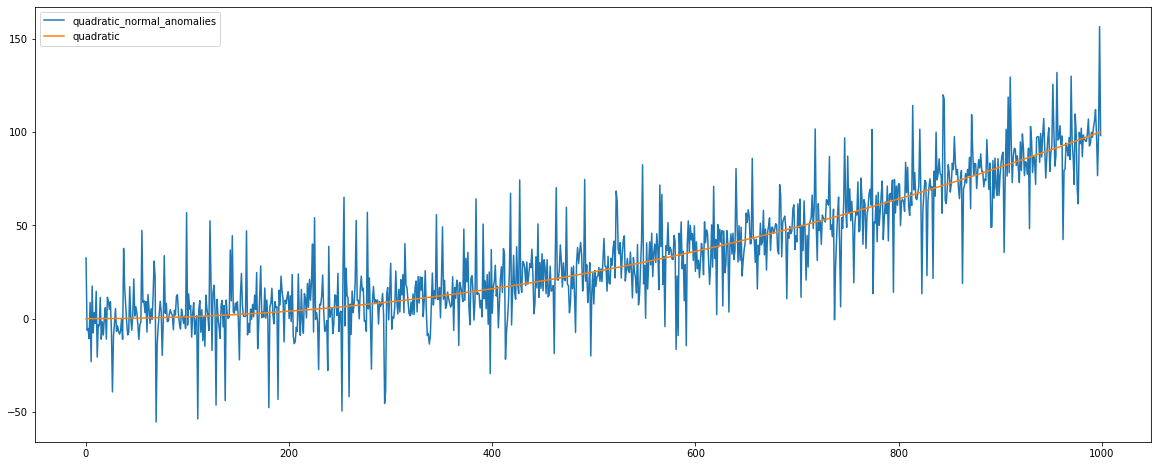

In [114]:
plt.plot(data["quadratic_normal_anomalies"], label="quadratic_normal_anomalies")
plt.plot(data["quadratic"], label="quadratic")
plt.legend()
plt.show()

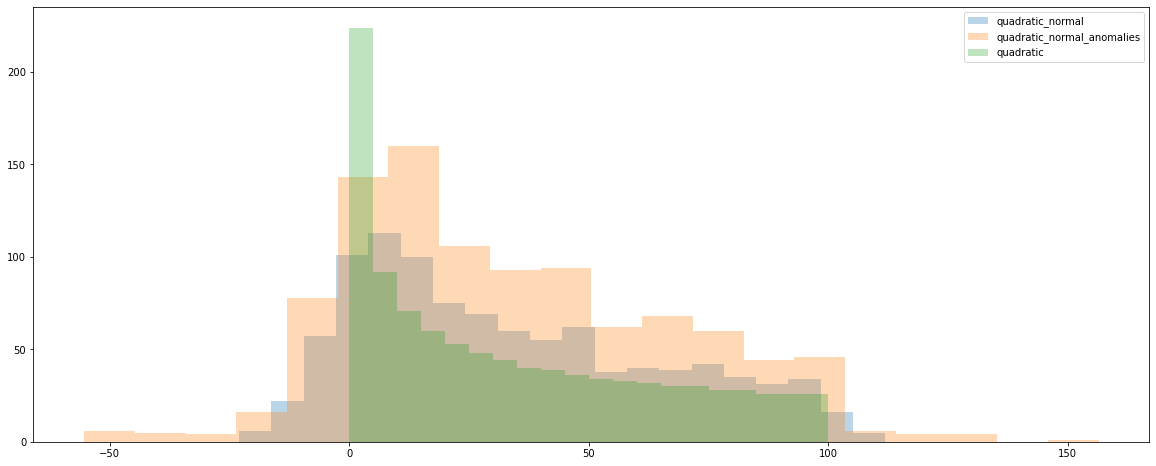

In [115]:
plt.hist(data["quadratic_normal"], bins=20, alpha=0.3, label="quadratic_normal")
plt.hist(data["quadratic_normal_anomalies"], bins=20, alpha=0.3, label="quadratic_normal_anomalies")
plt.hist(data["quadratic"], bins=20, alpha=0.3, label="quadratic")
plt.legend()
plt.show()

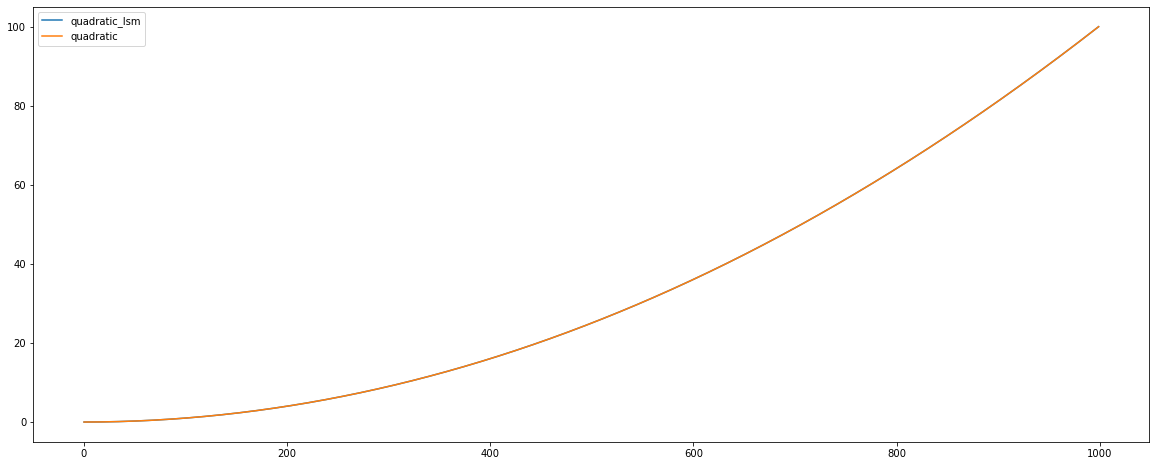

In [116]:
plt.plot(data["quadratic_lsm"], label="quadratic_lsm")
plt.plot(data["quadratic"], label="quadratic")
plt.legend()
plt.show()

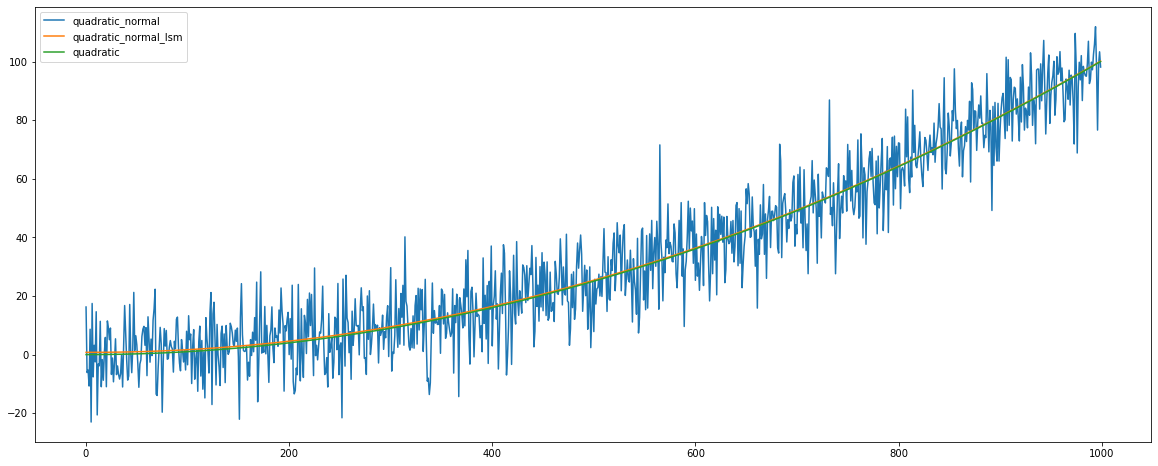

In [117]:
plt.plot(data["quadratic_normal"], label="quadratic_normal")
plt.plot(data["quadratic_normal_lsm"], label="quadratic_normal_lsm")
plt.plot(data["quadratic"], label="quadratic")
plt.legend()
plt.show()

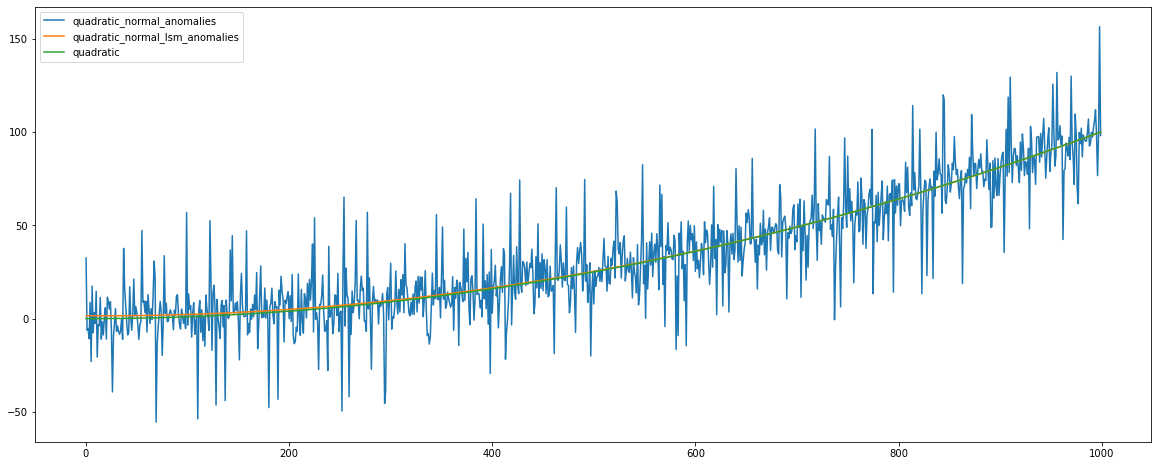

In [118]:
plt.plot(data["quadratic_normal_anomalies"], label="quadratic_normal_anomalies")
plt.plot(data["quadratic_normal_anomalies_lsm"], label="quadratic_normal_lsm_anomalies")
plt.plot(data["quadratic"], label="quadratic")
plt.legend()
plt.show()

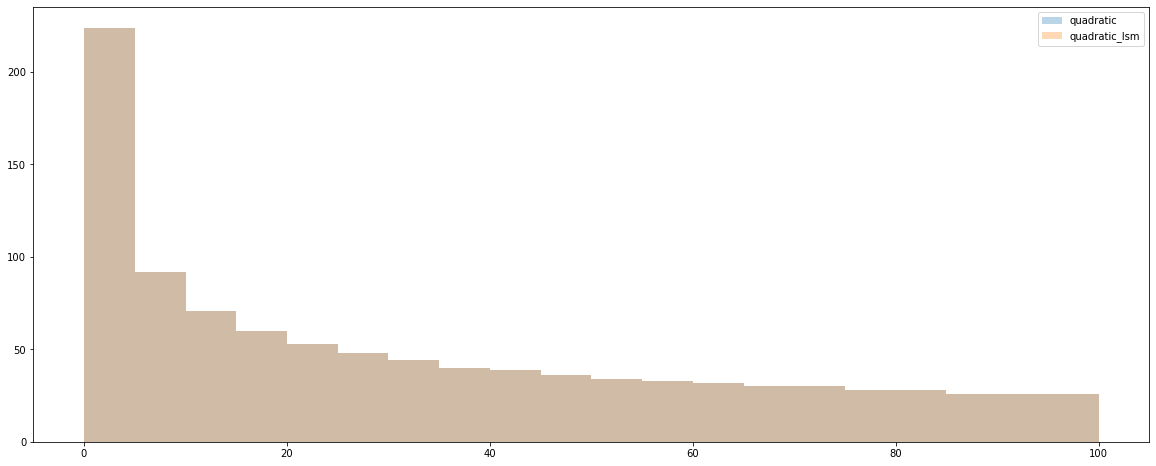

In [119]:
plt.hist(data["quadratic"], bins=20, alpha=0.3, label="quadratic")
plt.hist(data["quadratic_lsm"], bins=20, alpha=0.3, label="quadratic_lsm")
plt.legend()
plt.show()

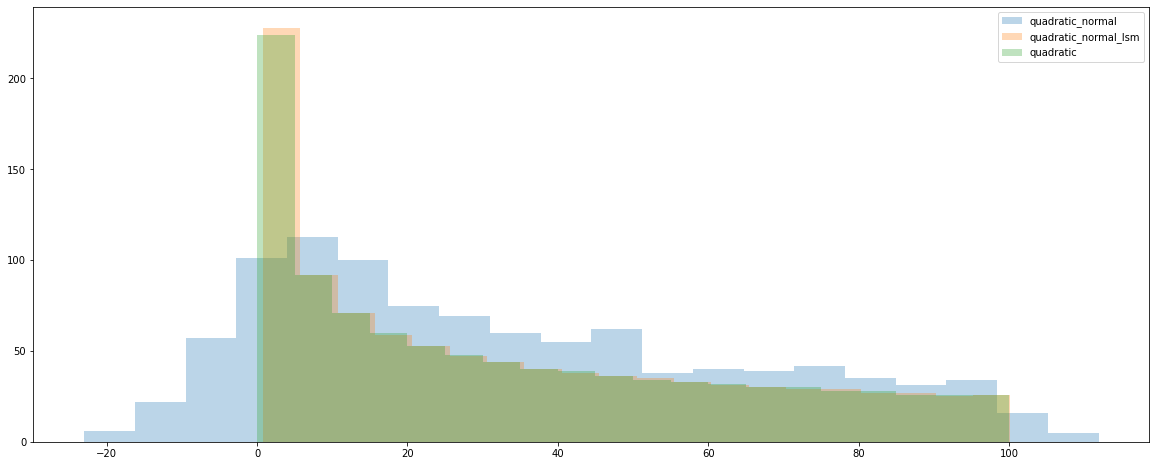

In [120]:
plt.hist(data["quadratic_normal"], bins=20, alpha=0.3, label="quadratic_normal")
plt.hist(data["quadratic_normal_lsm"], bins=20, alpha=0.3, label="quadratic_normal_lsm")
plt.hist(data["quadratic"], bins=20, alpha=0.3, label="quadratic")
plt.legend()
plt.show()

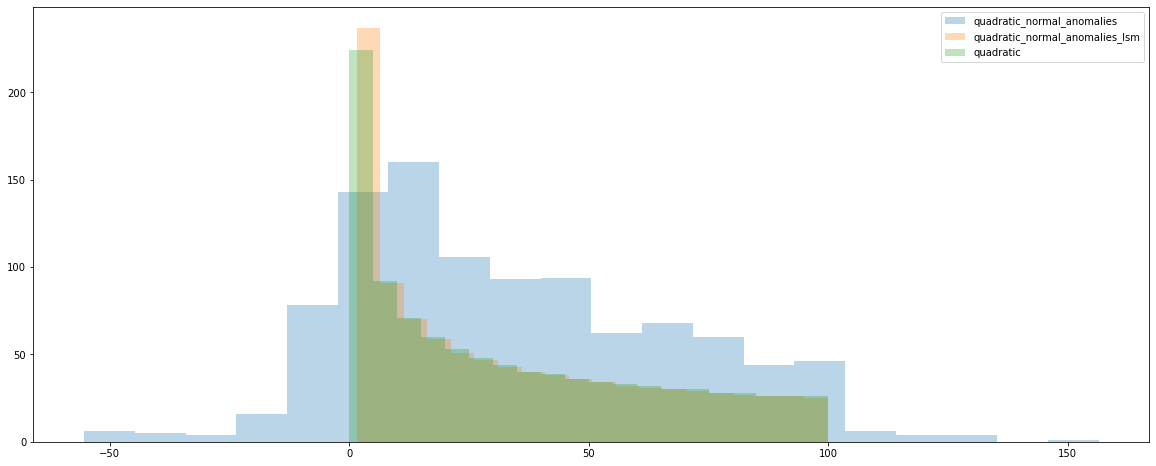

In [121]:
plt.hist(data["quadratic_normal_anomalies"], bins=20, alpha=0.3, label="quadratic_normal_anomalies")
plt.hist(data["quadratic_normal_anomalies_lsm"], bins=20, alpha=0.3, label="quadratic_normal_anomalies_lsm")
plt.hist(data["quadratic"], bins=20, alpha=0.3, label="quadratic")
plt.legend()
plt.show()

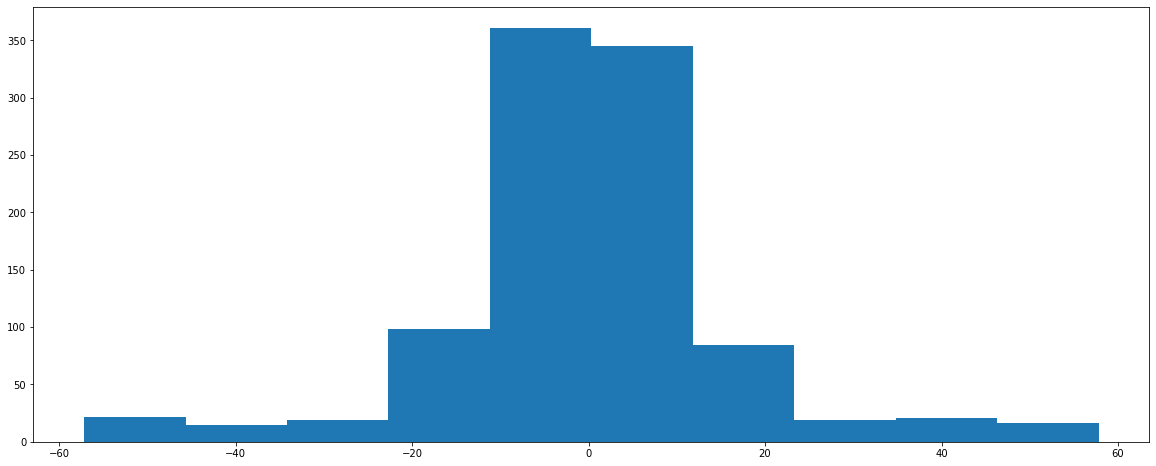

In [123]:
plt.hist(data["quadratic_normal_anomalies"] - data["quadratic_normal_anomalies_lsm"])
plt.show()

In [124]:
describe_all(data, "quadratic")

,quadratic_normal,quadratic_normal_anomalies,quadratic_lsm,quadratic_normal_lsm,quadratic_normal_anomalies_lsm,quadratic_normal_anomalies_fix
count,"1,000.000","1,000.000","1,000.000","1,000.000","1,000.000","1,000.000"
mean,0.388,0.443,0.000,0.388,0.443,0.610
std,9.815,16.185,0.000,0.180,0.493,13.707
min,-30.538,-55.862,-0.000,0.164,-0.087,-48.161
25%,-6.002,-6.742,0.000,0.226,-0.005,-6.136
50%,0.413,0.451,0.000,0.348,0.296,0.454
75%,7.040,7.815,0.000,0.530,0.817,7.409
max,39.586,58.613,0.000,0.773,1.559,48.987
var,96.333,261.955,0.000,0.032,0.243,187.875
